In [28]:
import numpy as np
import deeptrack as dt
import deeplay as dl
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch


In [29]:
image = dt.LoadImage("cope_1.png")
plt.figure(figsize=(15, 10))
image = np.array(image.resolve()) #Note to self, resolve() makes it into a list
print(np.shape(image))
#plt.imshow(image)

(5202, 3464, 3)


<Figure size 1500x1000 with 0 Axes>

# Prepare cropped sample

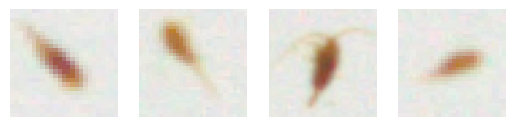

In [30]:
'''
Example crops for cope_1.png:

crop_size = 25
y_index = 1875
x_index = 1785

crop_size = 32
y_index = 1864
x_index = 920

crop_size = 40
y_index = 1970
x_index = 850

crop_size = 30
y_index = 2345
x_index = 1070

cope_2.png:

crop_size = 30
y_index = 1770
x_index = 608


crop_size = 35
y_index = 1675
x_index = 450
'''

crops = [25,32,40,30]
ys    = [1875,1864,1970,2345]
xs    = [1785,920,850,1070]

#x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
#training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])


for i in range(len(crops)):
    y_index = ys[i]
    x_index = xs[i]
    crop_size = crops[i]

    x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
    training_image = np.array(   image[x0:x0+crop_size, y0: y0 + crop_size])
    np.save(f"training_set/{i}.npy",training_image)
    plt.subplot(1,4,i+1)
    plt.axis("off")
    plt.imshow(training_image)


    


In [35]:
loader = dt.LoadImage(path="training_set/1.npy")


In [39]:

training_pipeline = (
    dt.Value(training_image)
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)
training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, replace=False)

TypeError: unsupported operand type(s) for >>: 'int' and 'Multiply'

In [22]:
dataloader = dl.DataLoader(training_dataset,batch_size=8,shuffle=True,num_workers=6)

# Train LodeSTAR with cropped sample

In [36]:
epochs = 5
lodestar = dl.LodeSTAR(n_transforms=4,optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=epochs)
trainer.fit(lodestar,dataloader)

INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_lo

Epoch 0:   0%|          | 0/50 [00:00<?, ?it/s] 

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/alex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/alex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/alex/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/pytorch/data.py", line 32, in __getitem__
    res =  self.pipeline(self.inputs[index])
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 192, in __call__
    output = super(Feature, self).__call__(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/backend/core.py", line 307, in __call__
    new_value = self.action(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 315, in action
    new_list = self._process_and_get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 710, in _image_wrapped_process_and_get
    new_list = self.get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 776, in get
    image = self.feature_1(image, _ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 192, in __call__
    output = super(Feature, self).__call__(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/backend/core.py", line 307, in __call__
    new_value = self.action(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 315, in action
    new_list = self._process_and_get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 710, in _image_wrapped_process_and_get
    new_list = self.get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 776, in get
    image = self.feature_1(image, _ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 192, in __call__
    output = super(Feature, self).__call__(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/backend/core.py", line 307, in __call__
    new_value = self.action(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 315, in action
    new_list = self._process_and_get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 710, in _image_wrapped_process_and_get
    new_list = self.get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 776, in get
    image = self.feature_1(image, _ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 192, in __call__
    output = super(Feature, self).__call__(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/backend/core.py", line 307, in __call__
    new_value = self.action(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 315, in action
    new_list = self._process_and_get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 710, in _image_wrapped_process_and_get
    new_list = self.get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 776, in get
    image = self.feature_1(image, _ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 192, in __call__
    output = super(Feature, self).__call__(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/backend/core.py", line 307, in __call__
    new_value = self.action(_ID=_ID)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 315, in action
    new_list = self._process_and_get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 710, in _image_wrapped_process_and_get
    new_list = self.get(image_list, **feature_input)
  File "/home/alex/.local/lib/python3.10/site-packages/deeptrack/features.py", line 1683, in get
    while ndim and image.ndim < ndim:
AttributeError: 'NoneType' object has no attribute 'ndim'


# Evaluate Performance

In [ ]:
#Prepare test image:
#crop_size= 2600
#y_index = 1900
#x_index = 1700
#x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
#test_image = image[x0:x0+crop_size, y0: y0 + crop_size]


#Downsample test image so it can be fed without crashing the pc
import cv2
rescale_factor = 0.7
new_width  = int(image.shape[1]*rescale_factor)
new_height = int(image.shape[0]*rescale_factor)
test_image = cv2.resize(image, (new_width,new_height),interpolation=cv2.INTER_AREA) 
torch_image = torch.from_numpy(test_image).permute(2,0,1).unsqueeze(0).float()


#Feed to LodeSTAR
prediction = lodestar(torch_image)[0].detach().numpy()

x, y, rho = prediction[0], prediction[1], prediction[-1]


plt.figure(figsize=(17,11))
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title("Input image")

plt.subplot(1,3,2)
plt.imshow(rho,cmap="grey")
plt.title("Predicted image")


#plt.subplot(1,3,3)
#plt.imshow(test_image)
#plt.scatter(y,x,alpha=rho.flatten()/rho.max(),s=0.0001)
#plt.title("input + predicted")



In [ ]:
alpha = 0.99
beta  = 0.99

cutoff = 0.2

mode= "constant"

plt.figure(figsize=(15, 10))
   
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                 mode="constant", cutoff=cutoff)[0]


plt.imshow(test_image, cmap="gray")
plt.scatter(detections[:, 1], detections[:, 0],marker="o",facecolors="none",edgecolors='r',linewidths=0.3)
plt.axis("off")

plt.show()